In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader


In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Define the amino acid alphabet
AMINO_ACIDS = 'ACDEFGHIKLMNPQRSTVWY'
AA_TO_IDX = {aa: idx for idx, aa in enumerate(AMINO_ACIDS)}
IDX_TO_AA = {idx: aa for idx, aa in enumerate(AMINO_ACIDS)}

class ProteinDataset(Dataset):
    """
    Custom dataset class for protein sequences and their properties.
    
    This class handles the conversion from amino acid sequences to numerical
    representations and manages the relationship between sequences and their
    target properties.
    """
    
    def __init__(self, sequences, targets, max_length=500):
        # If sequences/targets are pandas Series – drop old index and convert
        if isinstance(sequences, pd.Series):
            sequences = sequences.reset_index(drop=True).tolist()
        if isinstance(targets, pd.Series):
            targets = targets.reset_index(drop=True).tolist()

        self.sequences = sequences          # now a simple Python list
        self.targets   = targets            # plain list as well
        self.max_length = max_length

        # Normalise targets
        self.target_scaler = StandardScaler()
        self.normalized_targets = self.target_scaler.fit_transform(
            np.array(self.targets).reshape(-1, 1)
        ).flatten()

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        target   = self.normalized_targets[idx]

        sequence_tensor = self.sequence_to_tensor(sequence)
        target_tensor   = torch.tensor(target, dtype=torch.float32)
        return sequence_tensor, target_tensor
    
    def sequence_to_tensor(self, sequence):
        """
        Convert a protein sequence string to a one-hot encoded tensor.
        
        This function handles padding and truncation to ensure all sequences
        have the same length.
        """
        # Truncate if too long
        if len(sequence) > self.max_length:
            sequence = sequence[:self.max_length]
        
        # Create one-hot encoding
        tensor = torch.zeros(self.max_length, len(AMINO_ACIDS))
        
        for i, aa in enumerate(sequence):
            if aa in AA_TO_IDX:
                tensor[i, AA_TO_IDX[aa]] = 1.0
        
        return tensor
    
    def denormalize_target(self, normalized_value):
        """
        Convert normalized target back to original scale.
        
        This is useful for interpreting model predictions.
        """
        return self.target_scaler.inverse_transform([[normalized_value]])[0][0]

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ProteinCNN(nn.Module):
    """
    An intermediate CNN that balances complexity and regularization.
    - Restores one deeper convolutional layer to capture hierarchical patterns.
    - Uses a moderately sized fully-connected head.
    """ 

    def __init__(self, num_amino_acids=21, embedding_dim=64, num_filters=96, dropout_rate=0.4):
        """
        Initialize the intermediate CNN architecture.
        
        Args:
            num_amino_acids: Vocabulary size (e.g., 20 + 1 for padding).
            embedding_dim: Size of the learned embedding vector.
            num_filters: Number of filters. Increased slightly to 96 to give more capacity.
            dropout_rate: A more moderate dropout rate.
        """
        super(ProteinCNN, self).__init__()

        self.embedding = nn.Embedding(num_embeddings=num_amino_acids, embedding_dim=embedding_dim)

        # First block of convolutions with different kernel sizes
        self.conv1 = nn.Conv1d(embedding_dim, num_filters, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(embedding_dim, num_filters, kernel_size=5, padding=2)
        self.conv3 = nn.Conv1d(embedding_dim, num_filters, kernel_size=7, padding=3)

        self.batch_norm1 = nn.BatchNorm1d(num_filters)
        self.batch_norm2 = nn.BatchNorm1d(num_filters)
        self.batch_norm3 = nn.BatchNorm1d(num_filters)

        # --- RESTORED a deeper convolutional layer ---
        # This allows the model to learn combinations of the initial motifs.
        # It takes the concatenated output (num_filters * 3) as input.
        self.conv4 = nn.Conv1d(num_filters * 3, num_filters * 2, kernel_size=3, padding=1)
        self.batch_norm4 = nn.BatchNorm1d(num_filters * 2)
        
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        
        # --- FC head is more powerful than before, but simpler than original ---
        # The input is from conv4, which has num_filters * 2 channels.
        self.fc1 = nn.Linear(num_filters * 2, 256) 
        self.fc_out = nn.Linear(256, 1)
        
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x_one_hot):
        """
        Forward pass.
        
        Args:
            x_one_hot: Input tensor of one-hot vectors [batch, seq_len, num_amino_acids]
        """
        # Convert one-hot to indices on the fly
        x_indices = torch.argmax(x_one_hot, dim=2)
        
        x = self.embedding(x_indices)
        x = x.transpose(1, 2)
        
        # First conv block
        conv1_out = F.relu(self.batch_norm1(self.conv1(x)))
        conv2_out = F.relu(self.batch_norm2(self.conv2(x)))
        conv3_out = F.relu(self.batch_norm3(self.conv3(x)))
        
        x = torch.cat([conv1_out, conv2_out, conv3_out], dim=1)
        
        # --- Apply the deeper conv layer ---
        x = F.relu(self.batch_norm4(self.conv4(x)))
        x = self.dropout(x) # Apply dropout after the main conv blocks
        
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        
        # FC layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = self.fc_out(x)
        
        return x

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
from fpgen.prop_prediction.metrics import get_regression_metrics
import time

# Set random seeds for reproducibility
# This ensures that your results are consistent across runs
torch.manual_seed(42)
np.random.seed(42)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on: {device}")

Training on: cuda


In [13]:
import tqdm


def train_cnn_model(model, train_loader, val_loader, num_epochs=100, learning_rate=0.001):
    """
    Train the CNN model with careful monitoring and early stopping.
    
    This function implements best practices for training neural networks on small datasets,
    including learning rate scheduling, early stopping, and comprehensive monitoring.
    """
    print(torch.cuda.device_count())
    torch.cuda.set_device(0)
    # Move model to the appropriate device (GPU if available)
    model = model.to(device)
    # print devices
    
    
    # Choose optimizer and loss function
    # Adam is generally a good choice for CNNs because it adapts the learning rate
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    
    # Mean Squared Error for regression tasks
    criterion = nn.MSELoss()
    
    # Learning rate scheduler - reduces learning rate when validation loss plateaus
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', patience=10, factor=0.5
    )
    
    # Early stopping to prevent overfitting
    best_val_loss = float('inf')
    patience_counter = 0
    early_stopping_patience = 20
    
    # Track training history
    train_losses = []
    val_losses = []
    learning_rates = []
    
    print("Starting training...")
    print(f"Training batches per epoch: {len(train_loader)}")
    print(f"Validation batches per epoch: {len(val_loader)}")
    
    for epoch in tqdm.tqdm(range(num_epochs)):
        # Training phase
        model.train()  # Set model to training mode
        train_loss = 0.0
        train_batches = 0
        for batch_idx, (sequences, targets) in enumerate(train_loader):
            # Move data to device
            sequences = sequences.to(device)
            targets = targets.to(device)

            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            predictions = model(sequences)
            
            # Calculate loss
            loss = criterion(predictions.squeeze(), targets)
            
            # Backward pass
            loss.backward()
            
            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            # Update parameters
            optimizer.step()
            
            train_loss += loss.item()
            train_batches += 1
            
            # Print progress every 10 batches
            if batch_idx % 10 == 0:
                print(f'Epoch {epoch+1}, Batch {batch_idx}, Loss: {loss.item():.6f}')
        
        # Calculate average training loss
        avg_train_loss = train_loss / train_batches
        
        # Validation phase
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        val_batches = 0
        
        with torch.no_grad():  # Disable gradient computation for efficiency
            for sequences, targets in val_loader:
                sequences = sequences.to(device)
                targets = targets.to(device)
                
                predictions = model(sequences)
                loss = criterion(predictions.squeeze(), targets)
                
                val_loss += loss.item()
                val_batches += 1
        
        avg_val_loss = val_loss / val_batches
        
        # Record history
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        learning_rates.append(optimizer.param_groups[0]['lr'])
        
        # Print epoch summary
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  Train Loss: {avg_train_loss:.6f}')
        print(f'  Val Loss: {avg_val_loss:.6f}')
        print(f'  Learning Rate: {optimizer.param_groups[0]["lr"]:.8f}')
        print('-' * 50)
        
        # Learning rate scheduling
        scheduler.step(avg_val_loss)
        
        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            # Save the best model
            torch.save(model.state_dict(), 'best_cnn_model.pth')
            print(f'New best model saved with validation loss: {best_val_loss:.6f}')
        else:
            patience_counter += 1
            
        if patience_counter >= early_stopping_patience:
            print(f'Early stopping triggered after {epoch+1} epochs')
            break
    
    # Load the best model
    model.load_state_dict(torch.load('best_cnn_model.pth'))
    
    return model, train_losses, val_losses, learning_rates

In [14]:
def setup_data_loaders(fpbase_dataset, target_name='ex_max', batch_size=32, val_split=0.2):
    """
    Create training and validation data loaders using FPbase's train/test split.
    
    Args:
        fpbase_dataset: Instance of FPbase class
        target_name: Name of the target property (e.g., 'ex_max')
        batch_size: Batch size for DataLoader
        val_split: Fraction of training data to use for validation
    
    Returns:
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        test_loader: DataLoader for test data
        train_dataset: ProteinDataset instance for training data
    """
    
    # Get train and test data from FPbase
    x_train, y_train = fpbase_dataset.get_train(target_name, is_scaled=True)
    x_test, y_test = fpbase_dataset.get_test(target_name, is_scaled=True)
    
    # Create full training dataset
    train_full_dataset = ProteinDataset(x_train, y_train, max_length=500)
    
    # Split training data into train and validation
    total_size = len(train_full_dataset)
    train_size = int((1 - val_split) * total_size)
    val_size = total_size - train_size
    
    print(f"Full training set size: {total_size}")
    print(f"Training set size: {train_size}")
    print(f"Validation set size: {val_size}")
    print(f"Test set size: {len(x_test)}")
    
    # Split training dataset into train and validation
    train_dataset, val_dataset = random_split(
        train_full_dataset, 
        [train_size, val_size],
        generator=torch.Generator().manual_seed(42)  # For reproducibility
    )
    
    # Create test dataset
    test_dataset = ProteinDataset(x_test, y_test, max_length=500)
    
    # Create data loaders
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True,
        num_workers=0,
        pin_memory=True if torch.cuda.is_available() else False
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        shuffle=False,
        num_workers=0,
        pin_memory=True if torch.cuda.is_available() else False
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True if torch.cuda.is_available() else False
    )
    
    return train_loader, val_loader, test_loader, train_full_dataset

In [22]:
def evaluate_model(model, data_loader, dataset, fpbase_dataset, target_name='ex_max'):
    """
    Evaluate the trained model and calculate performance metrics.
    
    This function provides comprehensive evaluation including predictions
    on both normalized and original scales using FPbase rescaling.
    
    Args:
        model: The trained model
        data_loader: DataLoader with test/validation data
        dataset: ProteinDataset instance
        fpbase_dataset: FPbase instance for proper rescaling
        target_name: Name of the target property (default: 'ex_max')
    """
    
    model.eval()
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for sequences, targets in data_loader:
            sequences = sequences.to(device)
            targets = targets.to(device)
            
            predictions = model(sequences)
            
            all_predictions.extend(predictions.squeeze().cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    # Convert to numpy arrays
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    
    # Calculate metrics on normalized scale
    metrics_normalized = get_regression_metrics(all_predictions, all_targets)
    
    # Rescale using FPbase for interpretable metrics
    targets_original = fpbase_dataset.rescale_targets(all_targets, target_name)
    predictions_original = fpbase_dataset.rescale_targets(all_predictions, target_name)
    
    # Calculate metrics on original scale
    metrics_original = get_regression_metrics(predictions_original, targets_original)
    
    print("\nModel Evaluation Results:")
    print(f"Normalized metrics:")
    print(f"  R² Score: {metrics_normalized['r2']:.4f}")
    print(f"  RMSE: {metrics_normalized['rmse']:.4f}")
    print(f"  MAE: {metrics_normalized['mae']:.4f}")
    print(f"  Median AE: {metrics_normalized['mae_median']:.4f}")
    
    print(f"\nOriginal scale metrics:")
    print(f"  R² Score: {metrics_original['r2']:.4f}")
    print(f"  RMSE: {metrics_original['rmse']:.4f}")
    print(f"  MAE: {metrics_original['mae']:.4f}")
    print(f"  Median AE: {metrics_original['mae_median']:.4f}")
    
    return {
        'predictions_original': predictions_original,
        'targets_original': targets_original,
        **{f"{k}_original": v for k, v in metrics_original.items()},
        **{f"{k}_normalized": v for k, v in metrics_normalized.items()}
    }

def plot_training_history(train_losses, val_losses, learning_rates):
    """
    Visualize the training process to understand model behavior.
    
    These plots help you understand whether your model is learning properly,
    overfitting, or if you need to adjust hyperparameters.
    """
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot training and validation losses
    axes[0, 0].plot(train_losses, label='Training Loss', color='blue')
    axes[0, 0].plot(val_losses, label='Validation Loss', color='red')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Training and Validation Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Plot learning rate schedule
    axes[0, 1].plot(learning_rates, color='green')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Learning Rate')
    axes[0, 1].set_title('Learning Rate Schedule')
    axes[0, 1].set_yscale('log')
    axes[0, 1].grid(True)
    
    # Plot loss difference (overfitting indicator)
    loss_diff = np.array(val_losses) - np.array(train_losses)
    axes[1, 0].plot(loss_diff, color='purple')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Validation Loss - Training Loss')
    axes[1, 0].set_title('Overfitting Indicator')
    axes[1, 0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[1, 0].grid(True)
    
    # Plot validation loss with trend
    axes[1, 1].plot(val_losses, color='red', alpha=0.7)
    # Add trend line
    z = np.polyfit(range(len(val_losses)), val_losses, 1)
    p = np.poly1d(z)
    axes[1, 1].plot(range(len(val_losses)), p(range(len(val_losses))), 
                   color='black', linestyle='--', label='Trend')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Validation Loss')
    axes[1, 1].set_title('Validation Loss with Trend')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.show()

In [17]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [18]:
# Initialize FPbase dataset
from fpgen.prop_prediction.dataset import FPbase
dataset = FPbase()

# Create data loaders using FPbase's train/test split
batch_size = 32
train_loader, val_loader, test_loader, train_dataset = setup_data_loaders(
    fpbase_dataset=dataset,
    target_name='ex_max',
    batch_size=batch_size,
    val_split=0.2  # 20% of training data for validation
)

Full training set size: 676
Training set size: 540
Validation set size: 136
Test set size: 173


In [19]:
import torch
print("CUDA available :", torch.cuda.is_available())
print("GPU count       :", torch.cuda.device_count())
for i in range(torch.cuda.device_count()):
    print(f"GPU {i} name     :", torch.cuda.get_device_name(i))
    print(f"GPU {i} capability:",
          torch.cuda.get_device_capability(i))

CUDA available : True
GPU count       : 1
GPU 0 name     : NVIDIA GeForce RTX 4050 Laptop GPU
GPU 0 capability: (8, 9)


In [20]:
# Initialize model
model = ProteinCNN(
    num_amino_acids=20,  # Standard amino acids
    num_filters=128,
    dropout_rate=0.5
).to(device)

# Train model
print("Starting training...")
trained_model, train_losses, val_losses, learning_rates = train_cnn_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=200,
    learning_rate=0.001
)

Starting training...
1
Starting training...
Training batches per epoch: 17
Validation batches per epoch: 5


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1, Batch 0, Loss: 0.979916
Epoch 1, Batch 10, Loss: 0.997481


  0%|          | 1/200 [00:01<05:43,  1.73s/it]

Epoch 1/200:
  Train Loss: 0.886288
  Val Loss: 0.873382
  Learning Rate: 0.00100000
--------------------------------------------------
New best model saved with validation loss: 0.873382
Epoch 2, Batch 0, Loss: 0.651810
Epoch 2, Batch 10, Loss: 0.589478


  1%|          | 2/200 [00:02<03:54,  1.18s/it]

Epoch 2/200:
  Train Loss: 0.706279
  Val Loss: 0.428285
  Learning Rate: 0.00100000
--------------------------------------------------
New best model saved with validation loss: 0.428285
Epoch 3, Batch 0, Loss: 0.390892
Epoch 3, Batch 10, Loss: 0.496385


  2%|▏         | 3/200 [00:03<03:19,  1.01s/it]

Epoch 3/200:
  Train Loss: 0.674248
  Val Loss: 1.725047
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 4, Batch 0, Loss: 0.635388
Epoch 4, Batch 10, Loss: 0.354383


  2%|▏         | 4/200 [00:04<03:03,  1.07it/s]

Epoch 4/200:
  Train Loss: 0.650911
  Val Loss: 0.428231
  Learning Rate: 0.00100000
--------------------------------------------------
New best model saved with validation loss: 0.428231
Epoch 5, Batch 0, Loss: 0.552288
Epoch 5, Batch 10, Loss: 0.569501


  2%|▎         | 5/200 [00:05<02:56,  1.10it/s]

Epoch 5/200:
  Train Loss: 0.642601
  Val Loss: 0.460487
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 6, Batch 0, Loss: 0.404447
Epoch 6, Batch 10, Loss: 0.571959


  3%|▎         | 6/200 [00:05<02:52,  1.12it/s]

Epoch 6/200:
  Train Loss: 0.599871
  Val Loss: 1.792810
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 7, Batch 0, Loss: 0.661352
Epoch 7, Batch 10, Loss: 0.783421


  4%|▎         | 7/200 [00:06<02:50,  1.13it/s]

Epoch 7/200:
  Train Loss: 0.572477
  Val Loss: 1.488347
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 8, Batch 0, Loss: 0.863812
Epoch 8, Batch 10, Loss: 0.424375


  4%|▍         | 8/200 [00:07<02:48,  1.14it/s]

Epoch 8/200:
  Train Loss: 0.567409
  Val Loss: 0.471839
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 9, Batch 0, Loss: 0.408137
Epoch 9, Batch 10, Loss: 0.499353


  4%|▍         | 9/200 [00:08<02:48,  1.14it/s]

Epoch 9/200:
  Train Loss: 0.501987
  Val Loss: 0.550072
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 10, Batch 0, Loss: 0.573390
Epoch 10, Batch 10, Loss: 0.656938


  5%|▌         | 10/200 [00:09<02:49,  1.12it/s]

Epoch 10/200:
  Train Loss: 0.483261
  Val Loss: 2.730522
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 11, Batch 0, Loss: 0.247994
Epoch 11, Batch 10, Loss: 0.697128


  6%|▌         | 11/200 [00:10<02:47,  1.13it/s]

Epoch 11/200:
  Train Loss: 0.520883
  Val Loss: 1.174381
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 12, Batch 0, Loss: 0.650363
Epoch 12, Batch 10, Loss: 0.986790


  6%|▌         | 12/200 [00:11<02:44,  1.14it/s]

Epoch 12/200:
  Train Loss: 0.574403
  Val Loss: 6.197871
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 13, Batch 0, Loss: 0.517173
Epoch 13, Batch 10, Loss: 0.773378


  6%|▋         | 13/200 [00:11<02:41,  1.16it/s]

Epoch 13/200:
  Train Loss: 0.543535
  Val Loss: 0.476581
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 14, Batch 0, Loss: 0.469650
Epoch 14, Batch 10, Loss: 0.445503


  7%|▋         | 14/200 [00:12<02:39,  1.16it/s]

Epoch 14/200:
  Train Loss: 0.457454
  Val Loss: 0.670064
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 15, Batch 0, Loss: 0.430171
Epoch 15, Batch 10, Loss: 0.276077


  8%|▊         | 15/200 [00:13<02:39,  1.16it/s]

Epoch 15/200:
  Train Loss: 0.492783
  Val Loss: 6.925611
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 16, Batch 0, Loss: 0.834797
Epoch 16, Batch 10, Loss: 0.746995


  8%|▊         | 16/200 [00:14<02:37,  1.17it/s]

Epoch 16/200:
  Train Loss: 0.446669
  Val Loss: 1.914659
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 17, Batch 0, Loss: 0.466621
Epoch 17, Batch 10, Loss: 0.474807


  8%|▊         | 17/200 [00:15<02:35,  1.17it/s]

Epoch 17/200:
  Train Loss: 0.438788
  Val Loss: 5.767014
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 18, Batch 0, Loss: 0.350584
Epoch 18, Batch 10, Loss: 0.511089


  9%|▉         | 18/200 [00:16<02:35,  1.17it/s]

Epoch 18/200:
  Train Loss: 0.394870
  Val Loss: 3.165219
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 19, Batch 0, Loss: 0.826653
Epoch 19, Batch 10, Loss: 0.594827


 10%|▉         | 19/200 [00:17<02:34,  1.17it/s]

Epoch 19/200:
  Train Loss: 0.447318
  Val Loss: 0.411977
  Learning Rate: 0.00050000
--------------------------------------------------
New best model saved with validation loss: 0.411977
Epoch 20, Batch 0, Loss: 0.381748
Epoch 20, Batch 10, Loss: 0.208916


 10%|█         | 20/200 [00:17<02:33,  1.17it/s]

Epoch 20/200:
  Train Loss: 0.383016
  Val Loss: 0.380837
  Learning Rate: 0.00050000
--------------------------------------------------
New best model saved with validation loss: 0.380837
Epoch 21, Batch 0, Loss: 0.340265
Epoch 21, Batch 10, Loss: 0.274959


 10%|█         | 21/200 [00:18<02:32,  1.17it/s]

Epoch 21/200:
  Train Loss: 0.347810
  Val Loss: 2.044055
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 22, Batch 0, Loss: 0.360979
Epoch 22, Batch 10, Loss: 0.662805


 11%|█         | 22/200 [00:19<02:33,  1.16it/s]

Epoch 22/200:
  Train Loss: 0.408764
  Val Loss: 0.374441
  Learning Rate: 0.00050000
--------------------------------------------------
New best model saved with validation loss: 0.374441
Epoch 23, Batch 0, Loss: 0.385128
Epoch 23, Batch 10, Loss: 0.228385


 12%|█▏        | 23/200 [00:20<02:32,  1.16it/s]

Epoch 23/200:
  Train Loss: 0.427097
  Val Loss: 0.753301
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 24, Batch 0, Loss: 0.268393
Epoch 24, Batch 10, Loss: 0.374558


 12%|█▏        | 24/200 [00:21<02:31,  1.17it/s]

Epoch 24/200:
  Train Loss: 0.372623
  Val Loss: 0.491487
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 25, Batch 0, Loss: 0.179203
Epoch 25, Batch 10, Loss: 0.351304


 12%|█▎        | 25/200 [00:22<02:29,  1.17it/s]

Epoch 25/200:
  Train Loss: 0.333249
  Val Loss: 1.670371
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 26, Batch 0, Loss: 0.110342
Epoch 26, Batch 10, Loss: 0.495471


 13%|█▎        | 26/200 [00:23<02:27,  1.18it/s]

Epoch 26/200:
  Train Loss: 0.345812
  Val Loss: 1.144255
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 27, Batch 0, Loss: 0.435165
Epoch 27, Batch 10, Loss: 0.270265


 14%|█▎        | 27/200 [00:23<02:26,  1.18it/s]

Epoch 27/200:
  Train Loss: 0.318103
  Val Loss: 0.360675
  Learning Rate: 0.00050000
--------------------------------------------------
New best model saved with validation loss: 0.360675
Epoch 28, Batch 0, Loss: 0.138125
Epoch 28, Batch 10, Loss: 0.389796


 14%|█▍        | 28/200 [00:24<02:25,  1.18it/s]

Epoch 28/200:
  Train Loss: 0.329295
  Val Loss: 0.622093
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 29, Batch 0, Loss: 0.179791
Epoch 29, Batch 10, Loss: 0.478244


 14%|█▍        | 29/200 [00:25<02:24,  1.18it/s]

Epoch 29/200:
  Train Loss: 0.381900
  Val Loss: 0.363171
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 30, Batch 0, Loss: 0.218615
Epoch 30, Batch 10, Loss: 0.212192


 15%|█▌        | 30/200 [00:26<02:24,  1.18it/s]

Epoch 30/200:
  Train Loss: 0.298086
  Val Loss: 1.359288
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 31, Batch 0, Loss: 0.224090
Epoch 31, Batch 10, Loss: 0.226907


 16%|█▌        | 31/200 [00:27<02:24,  1.17it/s]

Epoch 31/200:
  Train Loss: 0.302956
  Val Loss: 0.334761
  Learning Rate: 0.00050000
--------------------------------------------------
New best model saved with validation loss: 0.334761
Epoch 32, Batch 0, Loss: 0.212598
Epoch 32, Batch 10, Loss: 0.528932


 16%|█▌        | 32/200 [00:28<02:23,  1.17it/s]

Epoch 32/200:
  Train Loss: 0.328874
  Val Loss: 0.389964
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 33, Batch 0, Loss: 0.161698
Epoch 33, Batch 10, Loss: 0.258145


 16%|█▋        | 33/200 [00:29<02:22,  1.17it/s]

Epoch 33/200:
  Train Loss: 0.292331
  Val Loss: 0.336330
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 34, Batch 0, Loss: 0.134299
Epoch 34, Batch 10, Loss: 0.148810


 17%|█▋        | 34/200 [00:29<02:22,  1.16it/s]

Epoch 34/200:
  Train Loss: 0.273138
  Val Loss: 2.919881
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 35, Batch 0, Loss: 0.440831
Epoch 35, Batch 10, Loss: 0.245895


 18%|█▊        | 35/200 [00:30<02:22,  1.16it/s]

Epoch 35/200:
  Train Loss: 0.299577
  Val Loss: 0.303751
  Learning Rate: 0.00050000
--------------------------------------------------
New best model saved with validation loss: 0.303751
Epoch 36, Batch 0, Loss: 0.337278
Epoch 36, Batch 10, Loss: 0.261636


 18%|█▊        | 36/200 [00:31<02:20,  1.16it/s]

Epoch 36/200:
  Train Loss: 0.296021
  Val Loss: 0.316767
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 37, Batch 0, Loss: 0.215381
Epoch 37, Batch 10, Loss: 0.218861


 18%|█▊        | 37/200 [00:32<02:20,  1.16it/s]

Epoch 37/200:
  Train Loss: 0.277364
  Val Loss: 0.552936
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 38, Batch 0, Loss: 0.340962
Epoch 38, Batch 10, Loss: 0.250494


 19%|█▉        | 38/200 [00:33<02:20,  1.16it/s]

Epoch 38/200:
  Train Loss: 0.298133
  Val Loss: 0.287619
  Learning Rate: 0.00050000
--------------------------------------------------
New best model saved with validation loss: 0.287619
Epoch 39, Batch 0, Loss: 0.256122
Epoch 39, Batch 10, Loss: 0.234958


 20%|█▉        | 39/200 [00:34<02:21,  1.14it/s]

Epoch 39/200:
  Train Loss: 0.245450
  Val Loss: 4.534322
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 40, Batch 0, Loss: 0.175710
Epoch 40, Batch 10, Loss: 0.291743


 20%|██        | 40/200 [00:35<02:19,  1.15it/s]

Epoch 40/200:
  Train Loss: 0.242962
  Val Loss: 0.386158
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 41, Batch 0, Loss: 0.126881
Epoch 41, Batch 10, Loss: 0.292641


 20%|██        | 41/200 [00:35<02:18,  1.15it/s]

Epoch 41/200:
  Train Loss: 0.222903
  Val Loss: 0.270781
  Learning Rate: 0.00050000
--------------------------------------------------
New best model saved with validation loss: 0.270781
Epoch 42, Batch 0, Loss: 0.235402
Epoch 42, Batch 10, Loss: 0.241569


 21%|██        | 42/200 [00:36<02:16,  1.16it/s]

Epoch 42/200:
  Train Loss: 0.220552
  Val Loss: 0.354405
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 43, Batch 0, Loss: 0.304801
Epoch 43, Batch 10, Loss: 0.233344


 22%|██▏       | 43/200 [00:37<02:15,  1.16it/s]

Epoch 43/200:
  Train Loss: 0.257289
  Val Loss: 0.303102
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 44, Batch 0, Loss: 0.168949
Epoch 44, Batch 10, Loss: 0.081789


 22%|██▏       | 44/200 [00:38<02:14,  1.16it/s]

Epoch 44/200:
  Train Loss: 0.240195
  Val Loss: 0.296082
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 45, Batch 0, Loss: 0.165271
Epoch 45, Batch 10, Loss: 0.181509


 22%|██▎       | 45/200 [00:39<02:13,  1.16it/s]

Epoch 45/200:
  Train Loss: 0.255671
  Val Loss: 0.342406
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 46, Batch 0, Loss: 0.199366
Epoch 46, Batch 10, Loss: 0.298284


 23%|██▎       | 46/200 [00:40<02:12,  1.16it/s]

Epoch 46/200:
  Train Loss: 0.220986
  Val Loss: 0.494395
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 47, Batch 0, Loss: 0.563494
Epoch 47, Batch 10, Loss: 0.105244


 24%|██▎       | 47/200 [00:41<02:11,  1.17it/s]

Epoch 47/200:
  Train Loss: 0.247986
  Val Loss: 0.342557
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 48, Batch 0, Loss: 0.129049
Epoch 48, Batch 10, Loss: 0.134451


 24%|██▍       | 48/200 [00:41<02:10,  1.17it/s]

Epoch 48/200:
  Train Loss: 0.215934
  Val Loss: 0.562060
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 49, Batch 0, Loss: 0.103492
Epoch 49, Batch 10, Loss: 0.296993


 24%|██▍       | 49/200 [00:42<02:09,  1.17it/s]

Epoch 49/200:
  Train Loss: 0.283570
  Val Loss: 0.294141
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 50, Batch 0, Loss: 0.203391
Epoch 50, Batch 10, Loss: 0.122831


 25%|██▌       | 50/200 [00:43<02:08,  1.17it/s]

Epoch 50/200:
  Train Loss: 0.199736
  Val Loss: 0.312143
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 51, Batch 0, Loss: 0.190476
Epoch 51, Batch 10, Loss: 0.302557


 26%|██▌       | 51/200 [00:44<02:07,  1.17it/s]

Epoch 51/200:
  Train Loss: 0.194885
  Val Loss: 0.416724
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 52, Batch 0, Loss: 0.131087
Epoch 52, Batch 10, Loss: 0.219949


 26%|██▌       | 52/200 [00:45<02:06,  1.17it/s]

Epoch 52/200:
  Train Loss: 0.199603
  Val Loss: 0.345965
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 53, Batch 0, Loss: 0.189931
Epoch 53, Batch 10, Loss: 0.163058


 26%|██▋       | 53/200 [00:46<02:06,  1.16it/s]

Epoch 53/200:
  Train Loss: 0.199555
  Val Loss: 0.305204
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 54, Batch 0, Loss: 0.146596
Epoch 54, Batch 10, Loss: 0.255684


 27%|██▋       | 54/200 [00:47<02:04,  1.17it/s]

Epoch 54/200:
  Train Loss: 0.241539
  Val Loss: 0.277191
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 55, Batch 0, Loss: 0.110017
Epoch 55, Batch 10, Loss: 0.223068


 28%|██▊       | 55/200 [00:47<02:04,  1.17it/s]

Epoch 55/200:
  Train Loss: 0.198693
  Val Loss: 0.295300
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 56, Batch 0, Loss: 0.164221
Epoch 56, Batch 10, Loss: 0.167231


 28%|██▊       | 56/200 [00:48<02:03,  1.17it/s]

Epoch 56/200:
  Train Loss: 0.169025
  Val Loss: 0.297303
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 57, Batch 0, Loss: 0.257916
Epoch 57, Batch 10, Loss: 0.132693


 28%|██▊       | 57/200 [00:49<02:01,  1.17it/s]

Epoch 57/200:
  Train Loss: 0.201685
  Val Loss: 0.247385
  Learning Rate: 0.00025000
--------------------------------------------------
New best model saved with validation loss: 0.247385
Epoch 58, Batch 0, Loss: 0.102951
Epoch 58, Batch 10, Loss: 0.161768


 29%|██▉       | 58/200 [00:50<02:01,  1.17it/s]

Epoch 58/200:
  Train Loss: 0.185769
  Val Loss: 0.250574
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 59, Batch 0, Loss: 0.162615
Epoch 59, Batch 10, Loss: 0.224079


 30%|██▉       | 59/200 [00:51<02:00,  1.17it/s]

Epoch 59/200:
  Train Loss: 0.179116
  Val Loss: 0.259867
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 60, Batch 0, Loss: 0.127935
Epoch 60, Batch 10, Loss: 0.312373


 30%|███       | 60/200 [00:52<01:59,  1.17it/s]

Epoch 60/200:
  Train Loss: 0.181248
  Val Loss: 0.338608
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 61, Batch 0, Loss: 0.071333
Epoch 61, Batch 10, Loss: 0.178854


 30%|███       | 61/200 [00:53<01:58,  1.17it/s]

Epoch 61/200:
  Train Loss: 0.160756
  Val Loss: 0.323801
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 62, Batch 0, Loss: 0.102384
Epoch 62, Batch 10, Loss: 0.169510


 31%|███       | 62/200 [00:53<01:57,  1.17it/s]

Epoch 62/200:
  Train Loss: 0.172132
  Val Loss: 0.271429
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 63, Batch 0, Loss: 0.161720
Epoch 63, Batch 10, Loss: 0.423527


 32%|███▏      | 63/200 [00:54<01:56,  1.17it/s]

Epoch 63/200:
  Train Loss: 0.203066
  Val Loss: 0.297690
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 64, Batch 0, Loss: 0.220331
Epoch 64, Batch 10, Loss: 0.187171


 32%|███▏      | 64/200 [00:55<01:56,  1.17it/s]

Epoch 64/200:
  Train Loss: 0.163483
  Val Loss: 0.247080
  Learning Rate: 0.00025000
--------------------------------------------------
New best model saved with validation loss: 0.247080
Epoch 65, Batch 0, Loss: 0.091845
Epoch 65, Batch 10, Loss: 0.123313


 32%|███▎      | 65/200 [00:56<01:54,  1.17it/s]

Epoch 65/200:
  Train Loss: 0.133844
  Val Loss: 0.316995
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 66, Batch 0, Loss: 0.139330
Epoch 66, Batch 10, Loss: 0.511390


 33%|███▎      | 66/200 [00:57<01:54,  1.17it/s]

Epoch 66/200:
  Train Loss: 0.184671
  Val Loss: 0.562541
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 67, Batch 0, Loss: 0.229704
Epoch 67, Batch 10, Loss: 0.171830


 34%|███▎      | 67/200 [00:58<01:54,  1.16it/s]

Epoch 67/200:
  Train Loss: 0.183310
  Val Loss: 0.265190
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 68, Batch 0, Loss: 0.135245
Epoch 68, Batch 10, Loss: 0.074491


 34%|███▍      | 68/200 [00:59<01:53,  1.16it/s]

Epoch 68/200:
  Train Loss: 0.212612
  Val Loss: 0.264399
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 69, Batch 0, Loss: 0.111432
Epoch 69, Batch 10, Loss: 0.668849


 34%|███▍      | 69/200 [00:59<01:52,  1.17it/s]

Epoch 69/200:
  Train Loss: 0.172132
  Val Loss: 0.259483
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 70, Batch 0, Loss: 0.112001
Epoch 70, Batch 10, Loss: 0.310458


 35%|███▌      | 70/200 [01:00<01:51,  1.17it/s]

Epoch 70/200:
  Train Loss: 0.187352
  Val Loss: 0.834213
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 71, Batch 0, Loss: 0.346927
Epoch 71, Batch 10, Loss: 0.105842


 36%|███▌      | 71/200 [01:01<01:51,  1.16it/s]

Epoch 71/200:
  Train Loss: 0.235685
  Val Loss: 0.261242
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 72, Batch 0, Loss: 0.205210
Epoch 72, Batch 10, Loss: 0.078219


 36%|███▌      | 72/200 [01:02<01:50,  1.16it/s]

Epoch 72/200:
  Train Loss: 0.157832
  Val Loss: 0.238720
  Learning Rate: 0.00025000
--------------------------------------------------
New best model saved with validation loss: 0.238720
Epoch 73, Batch 0, Loss: 0.120314
Epoch 73, Batch 10, Loss: 0.201320


 36%|███▋      | 73/200 [01:03<01:48,  1.17it/s]

Epoch 73/200:
  Train Loss: 0.161357
  Val Loss: 0.294612
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 74, Batch 0, Loss: 0.163141
Epoch 74, Batch 10, Loss: 0.585355


 37%|███▋      | 74/200 [01:04<01:47,  1.18it/s]

Epoch 74/200:
  Train Loss: 0.167032
  Val Loss: 0.251047
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 75, Batch 0, Loss: 0.275702
Epoch 75, Batch 10, Loss: 0.066572


 38%|███▊      | 75/200 [01:05<01:46,  1.18it/s]

Epoch 75/200:
  Train Loss: 0.144092
  Val Loss: 0.241187
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 76, Batch 0, Loss: 0.079422
Epoch 76, Batch 10, Loss: 0.486903


 38%|███▊      | 76/200 [01:05<01:45,  1.17it/s]

Epoch 76/200:
  Train Loss: 0.139520
  Val Loss: 0.253179
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 77, Batch 0, Loss: 0.149716
Epoch 77, Batch 10, Loss: 0.072628


 38%|███▊      | 77/200 [01:06<01:46,  1.16it/s]

Epoch 77/200:
  Train Loss: 0.133771
  Val Loss: 0.252454
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 78, Batch 0, Loss: 0.095918
Epoch 78, Batch 10, Loss: 0.110323


 39%|███▉      | 78/200 [01:07<01:46,  1.15it/s]

Epoch 78/200:
  Train Loss: 0.135761
  Val Loss: 0.228281
  Learning Rate: 0.00025000
--------------------------------------------------
New best model saved with validation loss: 0.228281
Epoch 79, Batch 0, Loss: 0.138497
Epoch 79, Batch 10, Loss: 0.112947


 40%|███▉      | 79/200 [01:08<01:45,  1.15it/s]

Epoch 79/200:
  Train Loss: 0.162748
  Val Loss: 0.249841
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 80, Batch 0, Loss: 0.121987
Epoch 80, Batch 10, Loss: 0.065664


 40%|████      | 80/200 [01:09<01:44,  1.15it/s]

Epoch 80/200:
  Train Loss: 0.134696
  Val Loss: 0.237765
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 81, Batch 0, Loss: 0.155992
Epoch 81, Batch 10, Loss: 0.413547


 40%|████      | 81/200 [01:10<01:43,  1.15it/s]

Epoch 81/200:
  Train Loss: 0.126179
  Val Loss: 0.251697
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 82, Batch 0, Loss: 0.185273
Epoch 82, Batch 10, Loss: 0.095251


 41%|████      | 82/200 [01:11<01:42,  1.16it/s]

Epoch 82/200:
  Train Loss: 0.143103
  Val Loss: 0.235267
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 83, Batch 0, Loss: 0.147348
Epoch 83, Batch 10, Loss: 0.259881


 42%|████▏     | 83/200 [01:12<01:41,  1.16it/s]

Epoch 83/200:
  Train Loss: 0.201031
  Val Loss: 0.315478
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 84, Batch 0, Loss: 0.073868
Epoch 84, Batch 10, Loss: 0.180056


 42%|████▏     | 84/200 [01:12<01:39,  1.16it/s]

Epoch 84/200:
  Train Loss: 0.180762
  Val Loss: 0.236115
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 85, Batch 0, Loss: 0.109971
Epoch 85, Batch 10, Loss: 0.078937


 42%|████▎     | 85/200 [01:13<01:39,  1.16it/s]

Epoch 85/200:
  Train Loss: 0.137687
  Val Loss: 0.282382
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 86, Batch 0, Loss: 0.044611
Epoch 86, Batch 10, Loss: 0.133446


 43%|████▎     | 86/200 [01:14<01:38,  1.16it/s]

Epoch 86/200:
  Train Loss: 0.157707
  Val Loss: 0.234942
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 87, Batch 0, Loss: 0.249543
Epoch 87, Batch 10, Loss: 0.199426


 44%|████▎     | 87/200 [01:15<01:36,  1.17it/s]

Epoch 87/200:
  Train Loss: 0.154542
  Val Loss: 0.248982
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 88, Batch 0, Loss: 0.086744
Epoch 88, Batch 10, Loss: 0.115911


 44%|████▍     | 88/200 [01:16<01:36,  1.16it/s]

Epoch 88/200:
  Train Loss: 0.146841
  Val Loss: 0.233677
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 89, Batch 0, Loss: 0.094576
Epoch 89, Batch 10, Loss: 0.215333


 44%|████▍     | 89/200 [01:17<01:35,  1.17it/s]

Epoch 89/200:
  Train Loss: 0.124574
  Val Loss: 0.927262
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 90, Batch 0, Loss: 0.162605
Epoch 90, Batch 10, Loss: 0.130005


 45%|████▌     | 90/200 [01:18<01:34,  1.16it/s]

Epoch 90/200:
  Train Loss: 0.232886
  Val Loss: 0.230588
  Learning Rate: 0.00012500
--------------------------------------------------
Epoch 91, Batch 0, Loss: 0.073242
Epoch 91, Batch 10, Loss: 0.107680


 46%|████▌     | 91/200 [01:18<01:34,  1.15it/s]

Epoch 91/200:
  Train Loss: 0.135796
  Val Loss: 0.233680
  Learning Rate: 0.00012500
--------------------------------------------------
Epoch 92, Batch 0, Loss: 0.084247
Epoch 92, Batch 10, Loss: 0.062053


 46%|████▌     | 92/200 [01:19<01:33,  1.16it/s]

Epoch 92/200:
  Train Loss: 0.142500
  Val Loss: 0.239071
  Learning Rate: 0.00012500
--------------------------------------------------
Epoch 93, Batch 0, Loss: 0.098539
Epoch 93, Batch 10, Loss: 0.083211


 46%|████▋     | 93/200 [01:20<01:31,  1.16it/s]

Epoch 93/200:
  Train Loss: 0.119935
  Val Loss: 0.231709
  Learning Rate: 0.00012500
--------------------------------------------------
Epoch 94, Batch 0, Loss: 0.071087
Epoch 94, Batch 10, Loss: 0.153901


 47%|████▋     | 94/200 [01:21<01:30,  1.17it/s]

Epoch 94/200:
  Train Loss: 0.140267
  Val Loss: 0.235027
  Learning Rate: 0.00012500
--------------------------------------------------
Epoch 95, Batch 0, Loss: 0.117428
Epoch 95, Batch 10, Loss: 0.083070


 48%|████▊     | 95/200 [01:22<01:29,  1.17it/s]

Epoch 95/200:
  Train Loss: 0.120468
  Val Loss: 0.232300
  Learning Rate: 0.00012500
--------------------------------------------------
Epoch 96, Batch 0, Loss: 0.072180
Epoch 96, Batch 10, Loss: 0.175690


 48%|████▊     | 96/200 [01:23<01:30,  1.15it/s]

Epoch 96/200:
  Train Loss: 0.108001
  Val Loss: 0.227537
  Learning Rate: 0.00012500
--------------------------------------------------
New best model saved with validation loss: 0.227537
Epoch 97, Batch 0, Loss: 0.291628
Epoch 97, Batch 10, Loss: 0.116582


 48%|████▊     | 97/200 [01:24<01:28,  1.16it/s]

Epoch 97/200:
  Train Loss: 0.120966
  Val Loss: 0.230110
  Learning Rate: 0.00012500
--------------------------------------------------
Epoch 98, Batch 0, Loss: 0.041431
Epoch 98, Batch 10, Loss: 0.113850


 49%|████▉     | 98/200 [01:24<01:28,  1.16it/s]

Epoch 98/200:
  Train Loss: 0.136237
  Val Loss: 0.236084
  Learning Rate: 0.00012500
--------------------------------------------------
Epoch 99, Batch 0, Loss: 0.083614
Epoch 99, Batch 10, Loss: 0.116160


 50%|████▉     | 99/200 [01:25<01:27,  1.16it/s]

Epoch 99/200:
  Train Loss: 0.111497
  Val Loss: 0.227783
  Learning Rate: 0.00012500
--------------------------------------------------
Epoch 100, Batch 0, Loss: 0.050119
Epoch 100, Batch 10, Loss: 0.056527


 50%|█████     | 100/200 [01:26<01:26,  1.16it/s]

Epoch 100/200:
  Train Loss: 0.093865
  Val Loss: 0.227054
  Learning Rate: 0.00012500
--------------------------------------------------
New best model saved with validation loss: 0.227054
Epoch 101, Batch 0, Loss: 0.085696
Epoch 101, Batch 10, Loss: 0.111003


 50%|█████     | 101/200 [01:27<01:25,  1.15it/s]

Epoch 101/200:
  Train Loss: 0.110542
  Val Loss: 0.230083
  Learning Rate: 0.00012500
--------------------------------------------------
Epoch 102, Batch 0, Loss: 0.079622
Epoch 102, Batch 10, Loss: 0.128542


 51%|█████     | 102/200 [01:28<01:24,  1.16it/s]

Epoch 102/200:
  Train Loss: 0.118671
  Val Loss: 0.246558
  Learning Rate: 0.00012500
--------------------------------------------------
Epoch 103, Batch 0, Loss: 0.081359
Epoch 103, Batch 10, Loss: 0.092633


 52%|█████▏    | 103/200 [01:29<01:24,  1.15it/s]

Epoch 103/200:
  Train Loss: 0.099424
  Val Loss: 0.233786
  Learning Rate: 0.00012500
--------------------------------------------------
Epoch 104, Batch 0, Loss: 0.095795
Epoch 104, Batch 10, Loss: 0.061302


 52%|█████▏    | 104/200 [01:30<01:23,  1.15it/s]

Epoch 104/200:
  Train Loss: 0.104525
  Val Loss: 0.218884
  Learning Rate: 0.00012500
--------------------------------------------------
New best model saved with validation loss: 0.218884
Epoch 105, Batch 0, Loss: 0.044595
Epoch 105, Batch 10, Loss: 0.043493


 52%|█████▎    | 105/200 [01:31<01:23,  1.14it/s]

Epoch 105/200:
  Train Loss: 0.092550
  Val Loss: 0.218377
  Learning Rate: 0.00012500
--------------------------------------------------
New best model saved with validation loss: 0.218377
Epoch 106, Batch 0, Loss: 0.037790
Epoch 106, Batch 10, Loss: 0.086794


 53%|█████▎    | 106/200 [01:31<01:22,  1.14it/s]

Epoch 106/200:
  Train Loss: 0.126657
  Val Loss: 0.218571
  Learning Rate: 0.00012500
--------------------------------------------------
Epoch 107, Batch 0, Loss: 0.143988
Epoch 107, Batch 10, Loss: 0.150406


 54%|█████▎    | 107/200 [01:32<01:22,  1.13it/s]

Epoch 107/200:
  Train Loss: 0.118773
  Val Loss: 0.231849
  Learning Rate: 0.00012500
--------------------------------------------------
Epoch 108, Batch 0, Loss: 0.106257
Epoch 108, Batch 10, Loss: 0.081993


 54%|█████▍    | 108/200 [01:33<01:21,  1.12it/s]

Epoch 108/200:
  Train Loss: 0.114225
  Val Loss: 0.231543
  Learning Rate: 0.00012500
--------------------------------------------------
Epoch 109, Batch 0, Loss: 0.083369
Epoch 109, Batch 10, Loss: 0.038843


 55%|█████▍    | 109/200 [01:34<01:20,  1.13it/s]

Epoch 109/200:
  Train Loss: 0.105932
  Val Loss: 0.219545
  Learning Rate: 0.00012500
--------------------------------------------------
Epoch 110, Batch 0, Loss: 0.107612
Epoch 110, Batch 10, Loss: 0.063095


 55%|█████▌    | 110/200 [01:35<01:19,  1.13it/s]

Epoch 110/200:
  Train Loss: 0.099593
  Val Loss: 0.237552
  Learning Rate: 0.00012500
--------------------------------------------------
Epoch 111, Batch 0, Loss: 0.167909
Epoch 111, Batch 10, Loss: 0.114617


 56%|█████▌    | 111/200 [01:36<01:18,  1.14it/s]

Epoch 111/200:
  Train Loss: 0.140090
  Val Loss: 0.245567
  Learning Rate: 0.00012500
--------------------------------------------------
Epoch 112, Batch 0, Loss: 0.076940
Epoch 112, Batch 10, Loss: 0.085864


 56%|█████▌    | 112/200 [01:37<01:16,  1.15it/s]

Epoch 112/200:
  Train Loss: 0.120821
  Val Loss: 0.224323
  Learning Rate: 0.00012500
--------------------------------------------------
Epoch 113, Batch 0, Loss: 0.411191
Epoch 113, Batch 10, Loss: 0.094664


 56%|█████▋    | 113/200 [01:38<01:15,  1.16it/s]

Epoch 113/200:
  Train Loss: 0.104737
  Val Loss: 0.220352
  Learning Rate: 0.00012500
--------------------------------------------------
Epoch 114, Batch 0, Loss: 0.478414
Epoch 114, Batch 10, Loss: 0.034653


 57%|█████▋    | 114/200 [01:38<01:14,  1.15it/s]

Epoch 114/200:
  Train Loss: 0.105996
  Val Loss: 0.232442
  Learning Rate: 0.00012500
--------------------------------------------------
Epoch 115, Batch 0, Loss: 0.127899
Epoch 115, Batch 10, Loss: 0.056482


 57%|█████▊    | 115/200 [01:39<01:13,  1.16it/s]

Epoch 115/200:
  Train Loss: 0.091956
  Val Loss: 0.226236
  Learning Rate: 0.00012500
--------------------------------------------------
Epoch 116, Batch 0, Loss: 0.089523
Epoch 116, Batch 10, Loss: 0.114217


 58%|█████▊    | 116/200 [01:40<01:12,  1.16it/s]

Epoch 116/200:
  Train Loss: 0.107140
  Val Loss: 0.239304
  Learning Rate: 0.00012500
--------------------------------------------------
Epoch 117, Batch 0, Loss: 0.117424
Epoch 117, Batch 10, Loss: 0.058084


 58%|█████▊    | 117/200 [01:41<01:12,  1.15it/s]

Epoch 117/200:
  Train Loss: 0.095367
  Val Loss: 0.219203
  Learning Rate: 0.00006250
--------------------------------------------------
Epoch 118, Batch 0, Loss: 0.128892
Epoch 118, Batch 10, Loss: 0.086243


 59%|█████▉    | 118/200 [01:42<01:11,  1.15it/s]

Epoch 118/200:
  Train Loss: 0.104779
  Val Loss: 0.213728
  Learning Rate: 0.00006250
--------------------------------------------------
New best model saved with validation loss: 0.213728
Epoch 119, Batch 0, Loss: 0.045481
Epoch 119, Batch 10, Loss: 0.094455


 60%|█████▉    | 119/200 [01:43<01:10,  1.15it/s]

Epoch 119/200:
  Train Loss: 0.106743
  Val Loss: 0.224155
  Learning Rate: 0.00006250
--------------------------------------------------
Epoch 120, Batch 0, Loss: 0.097091
Epoch 120, Batch 10, Loss: 0.253205


 60%|██████    | 120/200 [01:44<01:10,  1.13it/s]

Epoch 120/200:
  Train Loss: 0.089104
  Val Loss: 0.222265
  Learning Rate: 0.00006250
--------------------------------------------------
Epoch 121, Batch 0, Loss: 0.045656
Epoch 121, Batch 10, Loss: 0.124380


 60%|██████    | 121/200 [01:45<01:09,  1.14it/s]

Epoch 121/200:
  Train Loss: 0.092304
  Val Loss: 0.230652
  Learning Rate: 0.00006250
--------------------------------------------------
Epoch 122, Batch 0, Loss: 0.067853
Epoch 122, Batch 10, Loss: 0.076630


 61%|██████    | 122/200 [01:45<01:07,  1.16it/s]

Epoch 122/200:
  Train Loss: 0.103455
  Val Loss: 0.222918
  Learning Rate: 0.00006250
--------------------------------------------------
Epoch 123, Batch 0, Loss: 0.065088
Epoch 123, Batch 10, Loss: 0.104957


 62%|██████▏   | 123/200 [01:46<01:06,  1.15it/s]

Epoch 123/200:
  Train Loss: 0.096167
  Val Loss: 0.212916
  Learning Rate: 0.00006250
--------------------------------------------------
New best model saved with validation loss: 0.212916
Epoch 124, Batch 0, Loss: 0.039387
Epoch 124, Batch 10, Loss: 0.057117


 62%|██████▏   | 124/200 [01:47<01:05,  1.16it/s]

Epoch 124/200:
  Train Loss: 0.100023
  Val Loss: 0.229620
  Learning Rate: 0.00006250
--------------------------------------------------
Epoch 125, Batch 0, Loss: 0.054840
Epoch 125, Batch 10, Loss: 0.076110


 62%|██████▎   | 125/200 [01:48<01:04,  1.16it/s]

Epoch 125/200:
  Train Loss: 0.096265
  Val Loss: 0.216963
  Learning Rate: 0.00006250
--------------------------------------------------
Epoch 126, Batch 0, Loss: 0.055839
Epoch 126, Batch 10, Loss: 0.089197


 63%|██████▎   | 126/200 [01:49<01:04,  1.15it/s]

Epoch 126/200:
  Train Loss: 0.104850
  Val Loss: 0.214849
  Learning Rate: 0.00006250
--------------------------------------------------
Epoch 127, Batch 0, Loss: 0.108033
Epoch 127, Batch 10, Loss: 0.094471


 64%|██████▎   | 127/200 [01:50<01:03,  1.15it/s]

Epoch 127/200:
  Train Loss: 0.102443
  Val Loss: 0.226373
  Learning Rate: 0.00006250
--------------------------------------------------
Epoch 128, Batch 0, Loss: 0.045856
Epoch 128, Batch 10, Loss: 0.048961


 64%|██████▍   | 128/200 [01:51<01:02,  1.16it/s]

Epoch 128/200:
  Train Loss: 0.086958
  Val Loss: 0.232617
  Learning Rate: 0.00006250
--------------------------------------------------
Epoch 129, Batch 0, Loss: 0.073491
Epoch 129, Batch 10, Loss: 0.044317


 64%|██████▍   | 129/200 [01:51<01:01,  1.16it/s]

Epoch 129/200:
  Train Loss: 0.101987
  Val Loss: 0.227291
  Learning Rate: 0.00006250
--------------------------------------------------
Epoch 130, Batch 0, Loss: 0.023425
Epoch 130, Batch 10, Loss: 0.087788


 65%|██████▌   | 130/200 [01:52<01:00,  1.16it/s]

Epoch 130/200:
  Train Loss: 0.084573
  Val Loss: 0.220221
  Learning Rate: 0.00006250
--------------------------------------------------
Epoch 131, Batch 0, Loss: 0.089130
Epoch 131, Batch 10, Loss: 0.132628


 66%|██████▌   | 131/200 [01:53<00:59,  1.16it/s]

Epoch 131/200:
  Train Loss: 0.093823
  Val Loss: 0.215321
  Learning Rate: 0.00006250
--------------------------------------------------
Epoch 132, Batch 0, Loss: 0.067052
Epoch 132, Batch 10, Loss: 0.057790


 66%|██████▌   | 132/200 [01:54<00:59,  1.15it/s]

Epoch 132/200:
  Train Loss: 0.101457
  Val Loss: 0.221402
  Learning Rate: 0.00006250
--------------------------------------------------
Epoch 133, Batch 0, Loss: 0.277341
Epoch 133, Batch 10, Loss: 0.067187


 66%|██████▋   | 133/200 [01:55<00:58,  1.15it/s]

Epoch 133/200:
  Train Loss: 0.096414
  Val Loss: 0.222865
  Learning Rate: 0.00006250
--------------------------------------------------
Epoch 134, Batch 0, Loss: 0.068720
Epoch 134, Batch 10, Loss: 0.074154


 67%|██████▋   | 134/200 [01:56<00:57,  1.15it/s]

Epoch 134/200:
  Train Loss: 0.110056
  Val Loss: 0.224490
  Learning Rate: 0.00006250
--------------------------------------------------
Epoch 135, Batch 0, Loss: 0.077920
Epoch 135, Batch 10, Loss: 0.057949


 68%|██████▊   | 135/200 [01:57<00:56,  1.16it/s]

Epoch 135/200:
  Train Loss: 0.085996
  Val Loss: 0.219024
  Learning Rate: 0.00003125
--------------------------------------------------
Epoch 136, Batch 0, Loss: 0.068807
Epoch 136, Batch 10, Loss: 0.130620


 68%|██████▊   | 136/200 [01:57<00:55,  1.16it/s]

Epoch 136/200:
  Train Loss: 0.084543
  Val Loss: 0.231438
  Learning Rate: 0.00003125
--------------------------------------------------
Epoch 137, Batch 0, Loss: 0.062240
Epoch 137, Batch 10, Loss: 0.092826


 68%|██████▊   | 137/200 [01:58<00:53,  1.17it/s]

Epoch 137/200:
  Train Loss: 0.074028
  Val Loss: 0.222084
  Learning Rate: 0.00003125
--------------------------------------------------
Epoch 138, Batch 0, Loss: 0.052984
Epoch 138, Batch 10, Loss: 0.031193


 69%|██████▉   | 138/200 [01:59<00:53,  1.16it/s]

Epoch 138/200:
  Train Loss: 0.076163
  Val Loss: 0.229269
  Learning Rate: 0.00003125
--------------------------------------------------
Epoch 139, Batch 0, Loss: 0.039694
Epoch 139, Batch 10, Loss: 0.097350


 70%|██████▉   | 139/200 [02:00<00:52,  1.15it/s]

Epoch 139/200:
  Train Loss: 0.082109
  Val Loss: 0.219975
  Learning Rate: 0.00003125
--------------------------------------------------
Epoch 140, Batch 0, Loss: 0.126728
Epoch 140, Batch 10, Loss: 0.043631


 70%|███████   | 140/200 [02:01<00:52,  1.15it/s]

Epoch 140/200:
  Train Loss: 0.092451
  Val Loss: 0.217923
  Learning Rate: 0.00003125
--------------------------------------------------
Epoch 141, Batch 0, Loss: 0.041240
Epoch 141, Batch 10, Loss: 0.065730


 70%|███████   | 141/200 [02:02<00:51,  1.15it/s]

Epoch 141/200:
  Train Loss: 0.084316
  Val Loss: 0.225116
  Learning Rate: 0.00003125
--------------------------------------------------
Epoch 142, Batch 0, Loss: 0.060081
Epoch 142, Batch 10, Loss: 0.065484


 71%|███████   | 142/200 [02:03<00:50,  1.16it/s]

Epoch 142/200:
  Train Loss: 0.089546
  Val Loss: 0.215045
  Learning Rate: 0.00003125
--------------------------------------------------
Epoch 143, Batch 0, Loss: 0.140579
Epoch 143, Batch 10, Loss: 0.074934


 71%|███████   | 142/200 [02:04<00:50,  1.14it/s]

Epoch 143/200:
  Train Loss: 0.079659
  Val Loss: 0.219263
  Learning Rate: 0.00003125
--------------------------------------------------
Early stopping triggered after 143 epochs



Evaluating model on test set...

Model Evaluation Results:
Normalized metrics:
  R² Score: 0.6969
  RMSE: 0.5506
  MAE: 0.3611
  Median AE: 0.1985

Original scale metrics:
  R² Score: 0.6969
  RMSE: 36.7899
  MAE: 24.1266
  Median AE: 13.2653


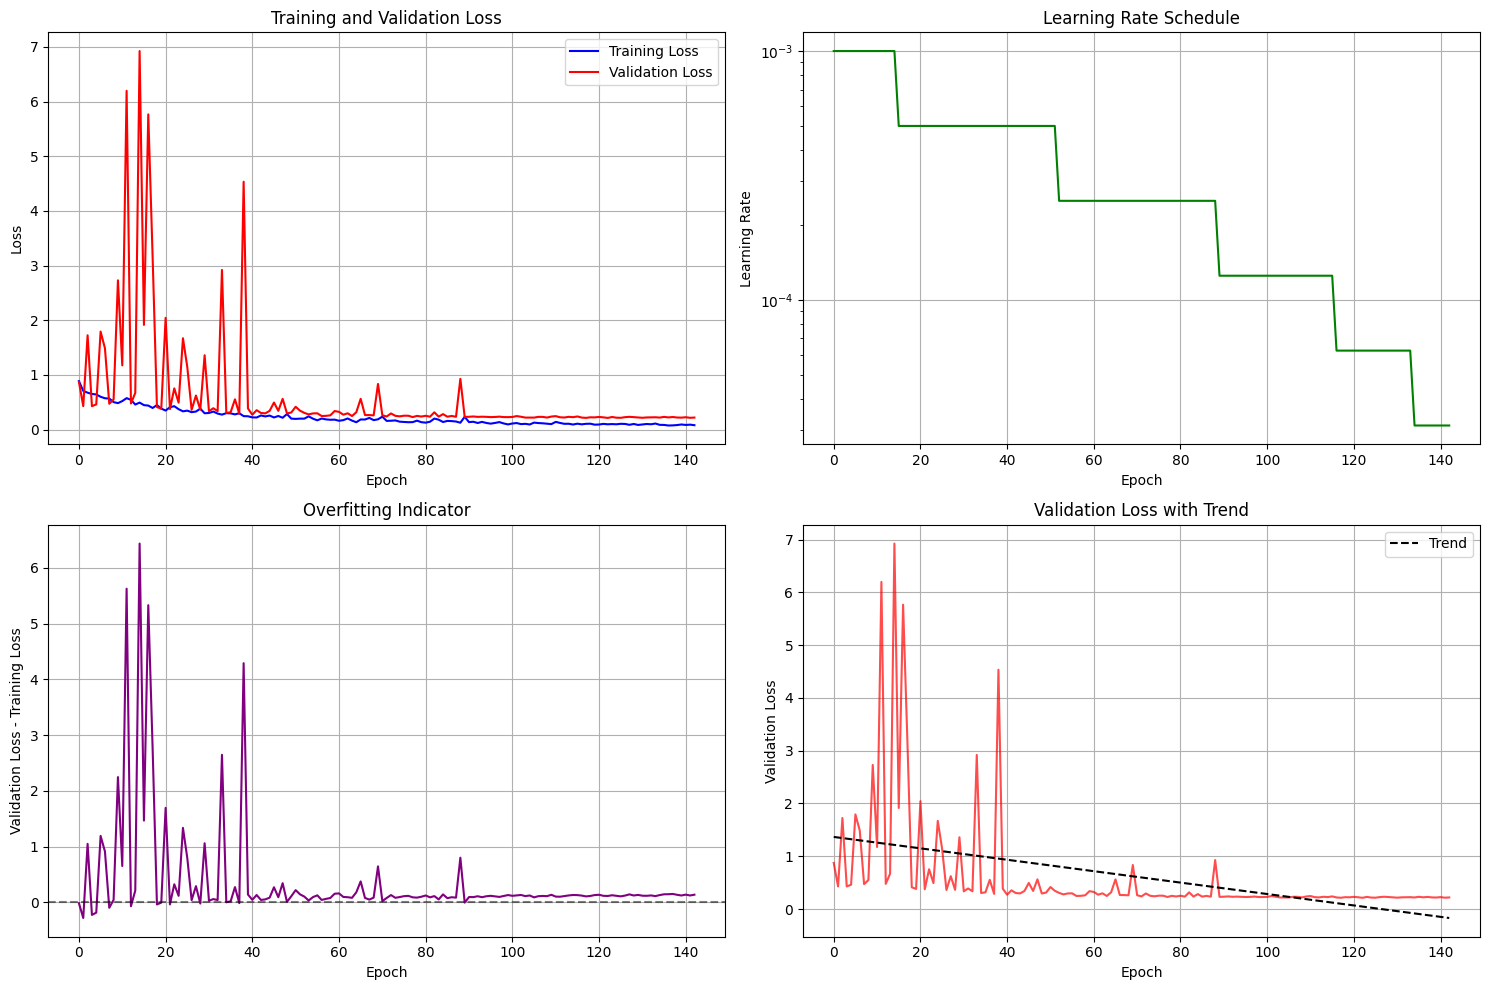

In [23]:
# Evaluate model on test set
print("\nEvaluating model on test set...")
evaluation_results = evaluate_model(
    model=trained_model,
    data_loader=test_loader,
    dataset=train_dataset,  # For normalization parameters
    fpbase_dataset=dataset,
    target_name='ex_max'
)

# Plot training history
plot_training_history(train_losses, val_losses, learning_rates)
